## Train LSTM model for power and energy prediction

### 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import mlflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from pathlib import Path

2025-03-25 02:37:31.499684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f"GPU is available and will be used: {gpus}")
else:
    print("No GPU detected, using CPU")

GPU is available and will be used: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 2: Define Hyperparameters

In [3]:
# Hyperparameters (previously handled by argparse)
csv_path = "/Users/kashmithnisakya/Developer/Data_Science/Energy-Prediction-System/ml/data/processed/china_mill_data_2025_03_04_09_30_30.csv"  # Replace with your actual CSV path
window_size = 672  # Input window size (e.g., 14 days with hourly data)
batch_size = 32
hidden_size = 50
num_layers = 2
epochs = 1
features = ['energy', 'power']  # Define features here as they were hardcoded

### 3: Data Loading and Preprocessing Function

In [4]:
def load_and_preprocess_data(csv_path, features, window_size):
    df = pd.read_csv(csv_path, parse_dates=['time'])
    df = df.sort_values('time').set_index('time')
    df = df[features].fillna(method='ffill')

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(window_size, len(scaled_data)):
        X.append(scaled_data[i - window_size:i])
        y.append(scaled_data[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler

### 4: Model Building Function

In [5]:
def build_model(input_shape, hidden_size, num_layers, output_size):
    model = Sequential()
    model.add(LSTM(hidden_size, return_sequences=(num_layers > 1), input_shape=input_shape))
    for _ in range(1, num_layers):
        model.add(LSTM(hidden_size, return_sequences=(_ < num_layers - 1)))
    model.add(Dense(output_size))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

### 5: Data Preparation

In [6]:
# Start MLflow run
mlflow.start_run()

# Log hyperparameters
mlflow.log_params({
    "window_size": window_size,
    "batch_size": batch_size,
    "hidden_size": hidden_size,
    "num_layers": num_layers,
    "epochs": epochs
})

# Load and preprocess data
X, y, scaler = load_and_preprocess_data(csv_path, features, window_size)

# Split into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Print shapes for verification
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

/var/folders/hz/hnfz7wcs2z368dvgpy7b4tx00000gn/T/ipykernel_32635/3275427306.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[features].fillna(method='ffill')


Training data shape: (103462, 672, 2), (103462, 2)
Testing data shape: (25866, 672, 2), (25866, 2)


### 6: Model Creation and Training

In [7]:
# Build the model
model = build_model((window_size, len(features)), hidden_size, num_layers, len(features))

2025-03-25 02:37:33.616792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-25 02:37:33.616864: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-25 02:37:33.851329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-25 02:37:33.852165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] 

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 672, 50)           10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 30,902
Trainable params: 30,902
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop],
    verbose=1
)

2025-03-25 02:37:34.848846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-25 02:37:34.850023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-25 02:37:34.850653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3234/3234 [==============================] - ETA: 0s - loss: 6.2426e-04 - mae: 0.0072

2025-03-25 02:41:41.200527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-25 02:41:41.201415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-25 02:41:41.201897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3234/3234 [==============================] - 263s 81ms/step - loss: 6.2426e-04 - mae: 0.0072 - val_loss: 4.7997e-04 - val_mae: 0.0146


### 7: Model Evaluation and Saving

In [11]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Log metrics to MLflow
mlflow.log_metrics({"loss": loss, "mae": mae})

# Save the model
model_path = Path("model/lstm_model.h5")
model.save(model_path)
mlflow.log_artifact(str(model_path))

# End MLflow run
mlflow.end_run()

print("Model training and saving completed")

809/809 [==============================] - 18s 22ms/step - loss: 4.7997e-04 - mae: 0.0146
Test Loss: 0.000479970796732232, Test MAE: 0.014574925415217876
Model training and saving completed


### 8: Plot Predictions

2025-03-25 02:42:16.100133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-25 02:42:16.101280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-25 02:42:16.101769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

  1/809 [..............................] - ETA: 6:54

2025-03-25 02:42:16.324255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


809/809 [==============================] - 17s 21ms/step


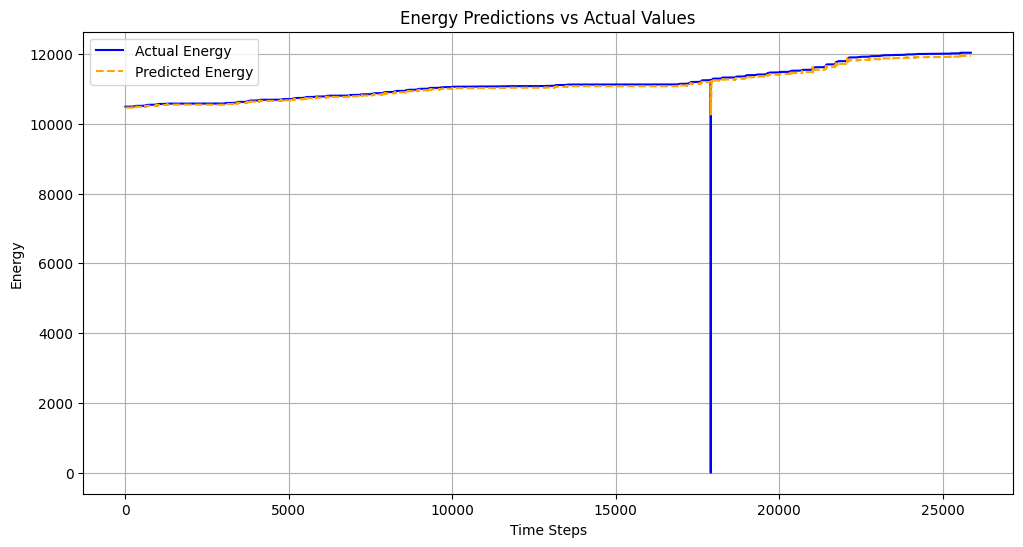

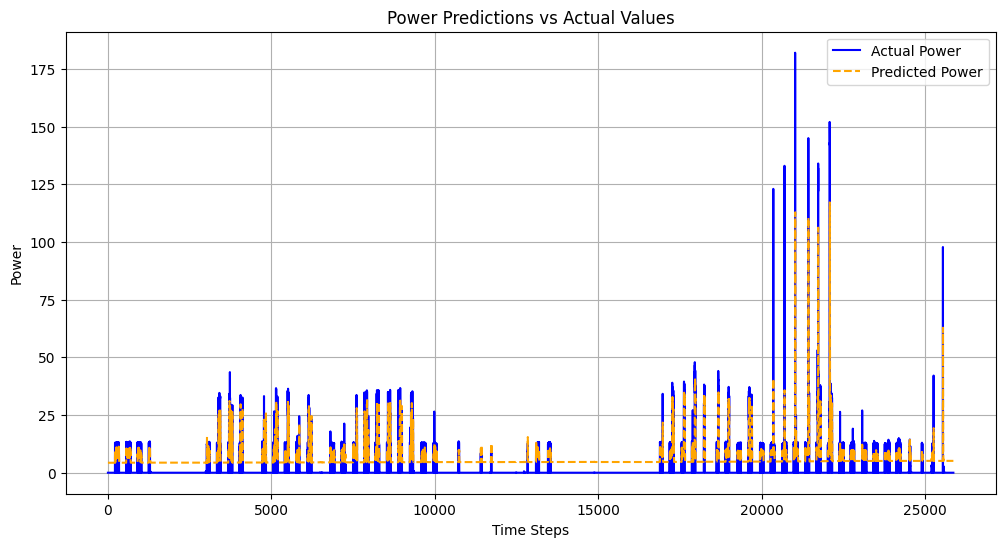

In [12]:
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot energy predictions (first feature)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 0], label='Actual Energy', color='blue')
plt.plot(y_pred_inv[:, 0], label='Predicted Energy', color='orange', linestyle='--')
plt.title('Energy Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Energy')
plt.legend()
plt.grid(True)
plt.show()

# Plot power predictions (second feature)
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[:, 1], label='Actual Power', color='blue')
plt.plot(y_pred_inv[:, 1], label='Predicted Power', color='orange', linestyle='--')
plt.title('Power Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Power')
plt.legend()
plt.grid(True)
plt.show()